# NSDF-SLAC raw data analysis

<div>
    <center>
        <img src="files/docs/Logo.png" width="250"/>
    </center>
</div>

Colaborators: 

* Stanford Linear Accelerator Center (SLAC) 
* Super Cryogenic Dark Matter Search (SuperCDMS)
* Sudbury Neutrino Observatory Lab (SNOLAB)
* National Science Data Fabric (NSDF)

NSDF-Team:

* Jack Marquez
* Heberth Martinez 
* Glenn Tarcea
* Giorgio Scorzelli
* Michela Taufer

## Preparing your Environment

The following cell prepares the environment by importing various crucial libraries for workflow execution. Please note that running this cell might take some time. Upon completion, a message will be displayed to notify you that the cell execution has finished.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import warnings
import boto3
from botocore.client import Config
import os
import concurrent
from convert import ConvertJob
warnings.filterwarnings("ignore")

print("You have successfully prepared your environment.")

You have successfully prepared your environment.


## Download CUTE Data from OSN


In [3]:
# CUTE data
src_endpoint_url="https://ncsa.osn.xsede.org"
src_bucket_name="supercdms-data"
# src_prefix="CDMS/CUTE"
# dst_prefix="files/raw_cute"
# UMN data
# src_endpoint_url="https://maritime.sealstorage.io/api/v0/s3"
# src_bucket_name="utah"
src_prefix="CDMS/UMN"
dst_prefix="files/raw_umn"

def Connect(profile_name,endpoint_url,bucket_name, verify=True):
	session=boto3.session.Session(profile_name=profile_name)
	resource=session.resource('s3', endpoint_url=endpoint_url,verify=verify)
	bucket = resource.Bucket(bucket_name)
	client = session.client('s3', endpoint_url=endpoint_url, verify=verify)
	return dict(session=session, resource=resource, bucket=bucket, client=client)

ConnectSrc=lambda : Connect(profile_name='osn',endpoint_url=src_endpoint_url, bucket_name=src_bucket_name)
# ConnectSrc=lambda : Connect(profile_name='slac_public',endpoint_url=src_endpoint_url, bucket_name=src_bucket_name, verify=False)



In [4]:
jobs=[]
max_files = 1
for k,it in enumerate(ConnectSrc()['bucket'].objects.filter(Prefix=src_prefix)):
		src_key=it.key
		if max_files and k>=max_files:
			break
		
		if src_key.endswith(".mid.gz"):
			local_filename=f"{dst_prefix}/{src_key}"
			dst_key=f"{dst_prefix}/{src_key}"
			done_filename=f"{local_filename}.done"
			# print (src_key,local_filename,dst_key,done_filename)
			if not os.path.exists(done_filename):
				pass
				os.makedirs(os.path.dirname(local_filename),exist_ok=True)
				print(f"Downloading {src_key} to {local_filename}")
				ConnectSrc()['bucket'].download_file(src_key, local_filename)
				print(f"Downloaded {src_key} to {local_filename}")
				print(f"Creating {done_filename}")
				open(done_filename, 'w').close()
				print(f"Created {done_filename}")
			else:
				print(f"Skipping {src_key} to {local_filename}")
			jobs.append((k,local_filename))
	
print(f"Total files: {len(jobs)}")

Total files: 0


## Convert Cute data to generate json, npz and xml


In [5]:
with concurrent.futures.ProcessPoolExecutor (max_workers=64) as executor:
    futures = [executor.submit(ConvertJob, *job) for job in jobs]
    for future in concurrent.futures.as_completed(futures):
        try:
            result = future.result()
            # print(f"Still todo {todo}")
        except Exception as ex:
            print(f'Error {ex}')

## Load data using Numpy

## Merging all the files to convert the data to IDX

In [15]:
import glob
pulses=[]
# for it in glob.glob("files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0001/**/data.npz",recursive=True):
for it in glob.glob("files/raw_umn/**/data.npz",recursive=True):
  pulses.append(np.array(np.load(it)["data"]))
  # print("found")
pulse=np.concatenate(pulses)
vmin=np.min(pulse)
vmax=np.max(pulse)
print("dtype",pulse.dtype,"shape", pulse.shape,"vmin",vmin,"vmax",vmax)
print("You have successfully merged the data files.")

dtype int64 shape (35022570,) vmin 0 vmax 3221225852
You have successfully merged the data files.


## IDX conversion

In [16]:
import shutil
import OpenVisus as ov
idx_filename='files/output/data.idx'

N=pulse.shape[0]
shutil.rmtree(os.path.splitext(os.path.dirname(idx_filename))[0], ignore_errors=True)
db=ov.CreateIdx(
  url=idx_filename, 
  dims=[N],
  fields=[ov.Field('data',ov.DType.fromString(str(pulse.dtype)),'row_major')], 
  compression="raw", 
  arco=f"{4*1024*1024}")
assert(os.path.isfile(idx_filename))

print("Writing data...")
logic_box=logic_box=ov.BoxNi(ov.PointNi([0]),ov.PointNi([N]))
db.write(pulse,  logic_box=logic_box)
print("write uncompressed data done","logic_box",logic_box.toString())

Writing data...
write uncompressed data done logic_box 0 35022570


## Compressing dataset

In [17]:
print("Compressing data")
db=ov.LoadDataset(idx_filename)
db.compressDataset("zip") 
print("compress dataset done")

Compressing data
compress dataset done


## Reading the dataset

In [18]:
idx_filename='files/output/data.idx'
db=ov.LoadDataset(idx_filename)
logic_box=db.getLogicBox()
print("logic_box",logic_box)
print("db.getMaxResolution()",db.getMaxResolution())
resolution=12
data=db.read(logic_box=logic_box, max_resolution=resolution)
print(f"IDX read done dtype={data.dtype} shape={data.shape} vmin={np.min(data)} vmax={np.max(data)}")


#full_res=db.read()
#np.save("fullres.npy",full_res)

logic_box ([0], [35022570])
db.getMaxResolution() 26
IDX read done dtype=int64 shape=(2138,) vmin=0 vmax=3221225488


## Plotting data
This plot can be integrated into the dashboard, so here is where we can add new visualizations

In [19]:
import bokeh
import bokeh.io 
bokeh.io.output_notebook()

Loading BokehJS ...

In [20]:
from bokeh.plotting import figure, show
p = bokeh.plotting.figure(title="Simple dashboard example", x_axis_label='x', y_axis_label='y')
y=data
x=list(range(len(y)))
p.line(x, y, legend_label="Pulse", line_width=1)
show(p)

In [ ]:
# load data using numpy
# npz = np.load("data.npz")
# npz = np.load("files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0001/events/00011/banks/SCD0/data.npz")
npz = np.load("files/raw_cute/CDMS/CUTE/23230808/Raw/23230808_020422/23230808_020422_F0001/events/00002/banks/LDV0/data.npz")
df = pd.DataFrame.from_dict({item: npz[item] for item in npz.files}, orient="columns")
index = pd.date_range("1/1/2000", periods=df.shape[0], freq="1S")
# print(df)
print(f"Data loaded successfully with shape {df.shape}")

Data loaded successfully with shape (526, 1)


* Plot raw data using Matplotlib 

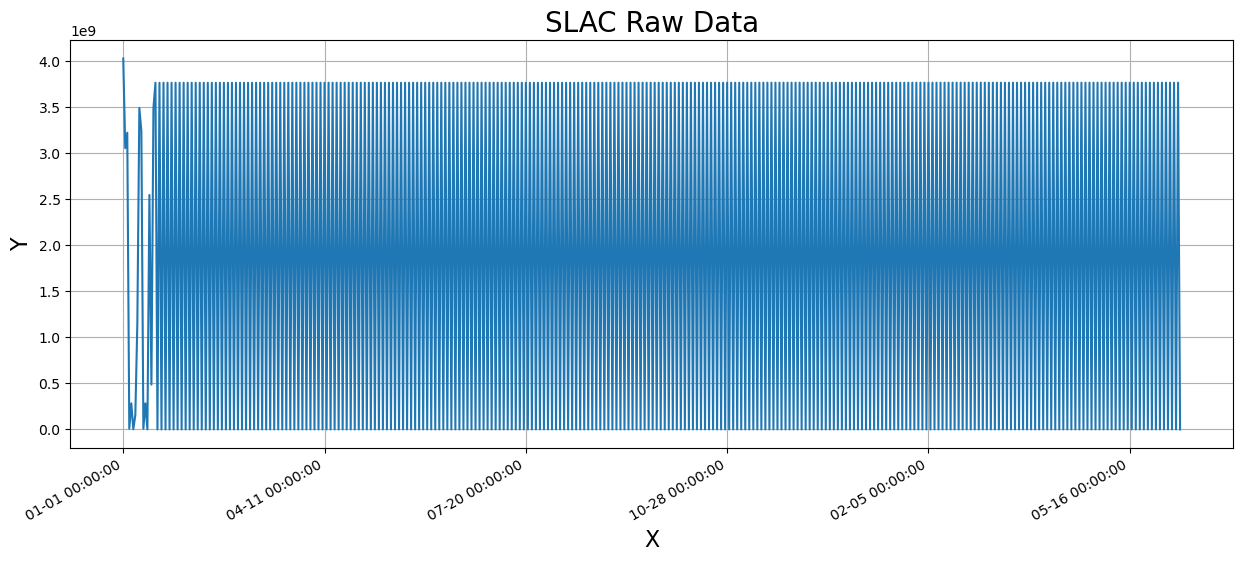

You have successfully plotted the data.


In [ ]:
myFmt = mdates.DateFormatter("%m-%d %H:%M:%S")
plt.figure(figsize=(15, 6))
plt.plot(df)
plt.title("SLAC Raw Data", fontsize=20)
plt.ylabel("Y", fontsize=16)
plt.xlabel("X", fontsize=16)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()
print("You have successfully plotted the data.")